In [2]:
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

In [3]:
# loading data after merging all last 12 months of ride data (jul 2023 to jun 2024)
df = pd.read_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\2022-2024\combined.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14541519 entries, 0 to 14541518
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 1.4+ GB


In [38]:
#stations dataframe
df2 = pd.read_csv(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\2022-2024\Divvy_Bicycle_Stations_20240814.csv')

In [39]:
df2.head()

,ID,Station Name,Short Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
0,a3ad5c90-a135-11e9-9cda-0a87ae2ba916,Dorchester Ave & 49th St,KA1503000069,15,15,In Service,41.805772,-87.592464,POINT (-87.592464 41.805772)
1,1571105068000485406,Narragansett & Irving Park,NaN,9,9,In Service,41.952614,-87.785383,POINT (-87.7853829 41.952614)
2,a3b2af02-a135-11e9-9cda-0a87ae2ba916,MLK Jr Dr & 83rd St,586,11,11,In Service,41.743116,-87.614800,POINT (-87.6148 41.743116)
3,1594046405283107528,California & 16th St,NaN,9,9,In Service,41.859228,-87.695562,POINT (-87.695562 41.859228)
4,a3b13836-a135-11e9-9cda-0a87ae2ba916,Kenton Ave & Madison St,537,11,11,In Service,41.880708,-87.741018,POINT (-87.741018 41.880708)


# A - Data cleaning:

## Setting requirement

1. [x] Adding calcualted columns: ride distance, time start, time end, ride length, week day, month, time
2. [x] Clean outliers data: check start date - end date logic 
3. [x] Convert start and end stations to neighourhoods
4. [x] Mapping neighborhood to stations data frame

### Adding calculated columns

In [5]:
# adding distance column using math library

import math

def haversine(row):
    start_lat, start_lgn = row['start_lat'], row['start_lng']
    end_lat, end_lng = row['end_lat'], row['end_lng']    

    # Convert latitude and longitude from degrees to radians
    start_lat = math.radians(start_lat)
    start_lgn = math.radians(start_lgn)
    end_lat = math.radians(end_lat)
    end_lng = math.radians(end_lng)

    # Differences between the two points
    dlat = start_lat - end_lat
    dlon = start_lgn - end_lng

    # Haversine formula
    a = math.sin(dlat / 2) ** 2 + math.cos(start_lat) * math.cos(end_lat) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth in kilometers. Use 3956 for miles
    R = 6371.0

    # Distance in kilometers
    distance = R * c

    return distance

In [6]:
# adding distance column to dataframe

df['distance_km'] = df.apply(haversine, axis =1)

In [7]:
df.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance_km
4947431,C7C9127B293364F7,electric_bike,2022-10-23 01:07:47,2022-10-23 01:14:02,Clarendon Ave & Gordon Ter,13379,None,None,41.957945,-87.649380,41.950000,-87.660000,member,1.245649
5551793,7A846D6AB87BED1C,electric_bike,2022-12-28 06:05:13,2022-12-28 06:09:21,None,None,Clark St & Winnemac Ave,TA1309000035,41.970000,-87.660000,41.973348,-87.667855,member,0.748536
13395844,873D99587EF2D8B0,electric_bike,2024-06-07 05:56:50.213,2024-06-07 06:04:21.032,Carpenter St & Huron St,13196,Franklin St & Adams St (Temp),TA1309000008,41.894508,-87.653573,41.879434,-87.635504,member,2.246533
9891953,E3C64AD37CDEBF96,electric_bike,2023-09-02 11:49:57,2023-09-02 12:43:06,None,None,DuSable Lake Shore Dr & North Blvd,LF-005,41.890000,-87.610000,41.911722,-87.626804,casual,2.787150
5485361,D2E4B96F08751835,classic_bike,2022-11-03 11:18:06,2022-11-03 11:22:00,Wabash Ave & Grand Ave,TA1307000117,Wells St & Hubbard St,TA1307000151,41.891466,-87.626761,41.889906,-87.634266,member,0.644995
4541723,D249FC5D9C7417F2,classic_bike,2022-09-26 17:04:49,2022-09-26 17:06:58,Wells St & Concord Ln,TA1308000050,Sedgwick St & North Ave,TA1307000038,41.912133,-87.634656,41.911386,-87.638677,member,0.342943
13275051,9E74DD6A5E9F96FF,electric_bike,2024-06-23 10:23:32.350,2024-06-23 10:35:57.825,Leavitt St & Addison St,KA1504000143,Larrabee St & Webster Ave,13193,41.946575,-87.683399,41.921822,-87.644140,casual,4.256988
11850490,1825B6D4789ED37D,electric_bike,2024-03-08 08:07:10,2024-03-08 08:07:26,Broadway & Waveland Ave,13325,Broadway & Waveland Ave,13325,41.949075,-87.648546,41.949074,-87.648636,casual,0.007416
3550146,F6DDE481E85A154B,electric_bike,2022-08-23 13:06:02,2022-08-23 13:10:38,LaSalle St & Jackson Blvd,TA1309000004,Canal St & Adams St,13011,41.878008,-87.631953,41.879255,-87.639904,casual,0.672735
7550274,2625DA07812EC59F,electric_bike,2023-06-14 07:05:30,2023-06-14 07:24:01,McCormick Place,TA1305000004,Canal St & Adams St,13011,41.851514,-87.618839,41.879255,-87.639904,member,3.543715


In [8]:
# convert started_at and ended_at to date time
df['started_at'] = pd.to_datetime(df['started_at'],format='mixed')
df['ended_at'] = pd.to_datetime(df['ended_at'], format='mixed')

In [9]:
# adding ride length:
df['ride_length'] = df['ended_at'] - df['started_at']

In [10]:
#sample data of ride_length

df['ride_length'].sample(10)

1062031           0 days 00:16:43
4550185           0 days 00:03:40
8499591           0 days 00:58:59
13400254   0 days 00:04:02.327000
5051614           0 days 00:10:37
12105769          0 days 00:04:53
6444363           0 days 00:09:33
4994263           0 days 00:05:22
14529637   0 days 01:43:29.537000
8320720           0 days 00:03:38
Name: ride_length, dtype: timedelta64[ns]

In [11]:
# convert ride length to minutes
df['ride_length_minutes'] = round(df['ride_length'].dt.total_seconds()/60,2)

In [12]:
df['distance_km'] = round(df['distance_km'],2)

In [13]:
# adding month column
df['month'] = df['started_at'].dt.month

In [14]:
df['year'] = df['started_at'].dt.year

In [16]:
# adding time column for the start of the ride
df['time'] = df['started_at'].dt.strftime('%H:%M')

In [17]:
df['time_hr'] = df['started_at'].dt.strftime('%H')

In [18]:
# adding day of week when the ride occured
df['day_of_week'] = df['started_at'].dt.day_name()

In [15]:
df.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance_km,ride_length,ride_length_minutes,month,time,date_diff
2600807,06702E36B2498B40,classic_bike,2023-10-23 09:21:20.000,2023-10-23 09:24:46.000,Blackstone Ave & 59th St,22004,University Ave & 59th St,22003,41.787877,-87.590461,41.787878,-87.598906,member,0.70,0 days 00:03:26,3.43,10,09:21,0
833617,C822079643FFB414,electric_bike,2023-08-16 18:01:05.000,2023-08-16 18:05:17.000,Clybourn Ave & Division St,TA1307000115,Wells St & Institute Pl,22001,41.904597,-87.640582,41.897380,-87.634420,casual,0.95,0 days 00:04:12,4.20,8,18:01,0
5456090,4BF42BF48FEB6A2E,electric_bike,2024-06-08 14:57:21.114,2024-06-08 15:14:15.302,None,None,None,None,41.980000,-87.650000,41.980000,-87.680000,member,2.48,0 days 00:16:54.188000,16.90,6,14:57,0
158137,975042D92E26FC4B,electric_bike,2023-07-27 18:35:47.000,2023-07-27 18:39:27.000,Morgan St & 18th St,13163,Clinton St & 18th St,TA1307000044,41.858045,-87.651030,41.857950,-87.640826,casual,0.85,0 days 00:03:40,3.67,7,18:35,0
3788142,B2F7CAD175B27ABF,classic_bike,2024-03-02 14:28:03.000,2024-03-02 15:03:45.000,Clark St & Elm St,TA1307000039,DuSable Lake Shore Dr & Monroe St,13300,41.902973,-87.631280,41.880958,-87.616743,casual,2.73,0 days 00:35:42,35.70,3,14:28,0
75069,B63A1455EE5DF5E1,classic_bike,2023-07-08 17:13:54.000,2023-07-08 17:18:09.000,Clark St & Drummond Pl,TA1307000142,Halsted St & Wrightwood Ave,TA1309000061,41.931248,-87.644336,41.929143,-87.649077,member,0.46,0 days 00:04:15,4.25,7,17:13,0
2448754,CA65DE005C2747E9,classic_bike,2023-10-03 08:22:40.000,2023-10-03 08:38:24.000,Halsted St & Fulton St,23003,Sedgwick St & Webster Ave,13191,41.886871,-87.648089,41.922167,-87.638888,casual,4.00,0 days 00:15:44,15.73,10,08:22,0
252778,E0341EB9131C7C56,classic_bike,2023-07-14 11:10:45.000,2023-07-14 11:23:13.000,Lincoln Ave & Belle Plaine Ave,TA1309000026,Damen Ave & Clybourn Ave,13271,41.956004,-87.680161,41.931931,-87.677856,member,2.68,0 days 00:12:28,12.47,7,11:10,0
3467037,42BF50DC83C93FEF,classic_bike,2024-01-25 14:40:03.000,2024-01-25 15:06:37.000,Clark St & Lake St,KA1503000012,Conservatory Dr & Lake St,518,41.886021,-87.630876,41.885502,-87.716866,casual,7.12,0 days 00:26:34,26.57,1,14:40,0
3192857,337634ED7E324EF9,classic_bike,2023-12-25 10:54:27.000,2023-12-25 11:04:02.000,Clark St & Drummond Pl,TA1307000142,Southport Ave & Wrightwood Ave,TA1307000113,41.931248,-87.644336,41.928773,-87.663913,member,1.64,0 days 00:09:35,9.58,12,10:54,0


### Clean outliers

In [19]:
df['date_diff'] = df['ride_length'].dt.days

In [20]:
row_to_drop = df[df['date_diff'] < 0].index

In [21]:
df = df.drop(row_to_drop, axis = 0)

In [22]:
# drop date_diff
df = df.drop('date_diff', axis=1)

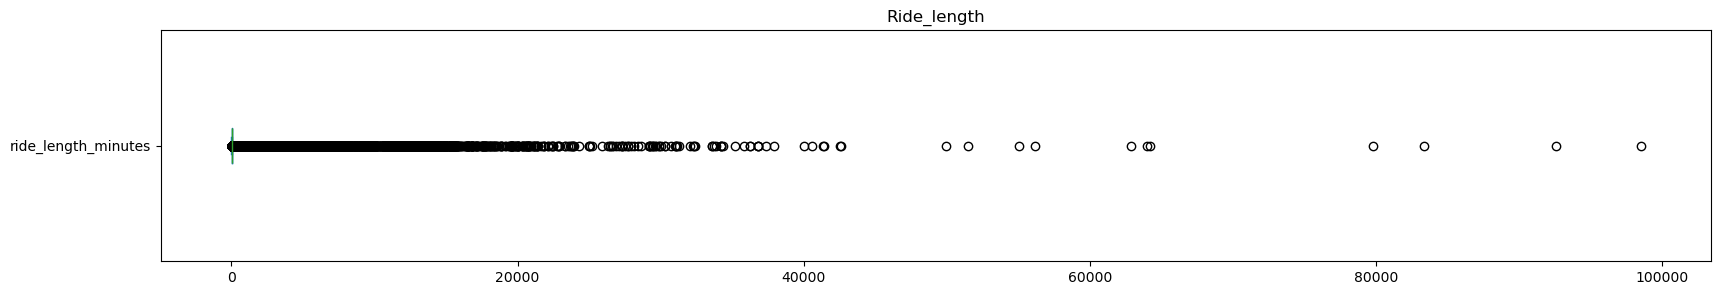

The upper limit for price is 35.894999999999996
The lower limit for price is -12.544999999999998
There are 1079503 rows have price higher than upper limit accounting for 7.42% of total


In [23]:
# clean out trips that has outliers length

fig, ax = plt.subplots(figsize=(20,3))
df['ride_length_minutes'].plot(kind = 'box', vert = False)
ax.set_title('Ride_length')
plt.show()

# identify the outliers with 1.5*IQR rules - price column:
length_Q1 = df['ride_length_minutes'].quantile(0.25)
length_Q3 = df['ride_length_minutes'].quantile(0.75)
length_IQR = length_Q3 - length_Q1
length_upper_bound = length_Q3 + 1.5*length_IQR
length_lower_bound = length_Q1 - 1.5*length_IQR
upper_num = len(df[df['ride_length_minutes'] > length_upper_bound])

print(f'The upper limit for price is {length_upper_bound}')
print(f'The lower limit for price is {length_lower_bound}')
print(f'There are {upper_num} rows have price higher than upper limit accounting for {round(upper_num*100/len(df),2)}% of total')

In [24]:
# drop outliers trip length
df = df.drop(df[df['ride_length_minutes']> length_upper_bound].index, axis = 0)

### Adding neighborhoods area: 
For the ease of visualization about the utilization of bikes in specific neighborhoods, I made use of the geojson file of Chicago and map out the specific neighborhoods to start and end location.

In [25]:
import geopandas as gpd
from shapely.geometry import Point

In [26]:
# loading the neighbourhoods map
neighborhoods = gpd.read_file(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\Data analytics\chicago.geojson')

c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [27]:
geometry = [Point(xy) for xy in zip(df.start_lng, df.start_lat)]

In [28]:
# Convert DataFrame to GeoDataFrame
df = gpd.GeoDataFrame(df, geometry=geometry)

In [29]:
# Set the same coordinate reference system (CRS) for both GeoDataFrames
df.crs = neighborhoods.crs

In [30]:
# Perform spatial join to assign neighborhood names to each bike station
df = gpd.sjoin(df, neighborhoods, how='left', op='within')

c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [31]:
column_to_drop2 = ['geometry','index_right','cartodb_id','created_at','updated_at']

In [32]:
df = df.drop(column_to_drop2, axis = 1)

In [33]:
df.rename(columns = {'name' : 'start_neighborhood'}, inplace = True)

In [34]:
# repeat the same routine for end neigbourhood:
geometry2 = [Point(xy) for xy in zip(df.end_lng, df.end_lat)]
df = gpd.GeoDataFrame(df, geometry=geometry2)

In [35]:
df.crs = neighborhoods.crs
df = gpd.sjoin(df, neighborhoods, how='left', op='within')


c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [36]:
df = df.drop(column_to_drop2, axis = 1)
df.rename(columns = {'name' : 'end_neighborhood'}, inplace = True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14540968 entries, 0 to 14541518
Data columns (total 23 columns):
 #   Column               Dtype          
---  ------               -----          
 0   ride_id              object         
 1   rideable_type        object         
 2   started_at           datetime64[ns] 
 3   ended_at             datetime64[ns] 
 4   start_station_name   object         
 5   start_station_id     object         
 6   end_station_name     object         
 7   end_station_id       object         
 8   start_lat            float64        
 9   start_lng            float64        
 10  end_lat              float64        
 11  end_lng              float64        
 12  member_casual        object         
 13  distance_km          float64        
 14  ride_length          timedelta64[ns]
 15  ride_length_minutes  float64        
 16  month                int32          
 17  year                 int32          
 18  time                 object         
 19  tim

### Mapping neighborhood to stations data frame

In [70]:
geometry3 = df2['Location'].apply(lambda x: Point(float(x.split()[1][1:]), float(x.split()[2][:-1])))

In [72]:
df2 = gpd.GeoDataFrame(df2, geometry=geometry3)

df2.crs = neighborhoods.crs

df2 = gpd.sjoin(df2, neighborhoods, how='left', op='within')

c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [ ]:
df2 = df2.drop(column_to_drop2,axis =1)
df2.rename(columns={'name':'station_neighborhood'}, inplace= True)

In [75]:
df2.sample()

,ID,Station Name,Short Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location,station_neighborhood
662,1448642183732401788,Maryland Ave & 104th St,NaN,10,10,In Service,41.705588,-87.602938,POINT (-87.602938 41.705588),Pullman


# B - Data exploratory analysis
What is the landscape look like over the last 12 months


## 1. Bike ride characteristics:
- [ ] What is the seasonality characteristics of bike sharing? Identify the peak months, peak hours of ride
- [ ] What are the most popular routes of ride?

In [46]:
df_ltm = df[(df['started_at'] <= '2024-07-31') & (df['started_at'] >= '2023-08-01')]

In [47]:
len(df_ltm)

5284068

In [48]:
# monthly ride number
ride_by_month = df_ltm.groupby('month').count()['ride_id'].reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ride_by_month['month'] = month_order
ride_by_month.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

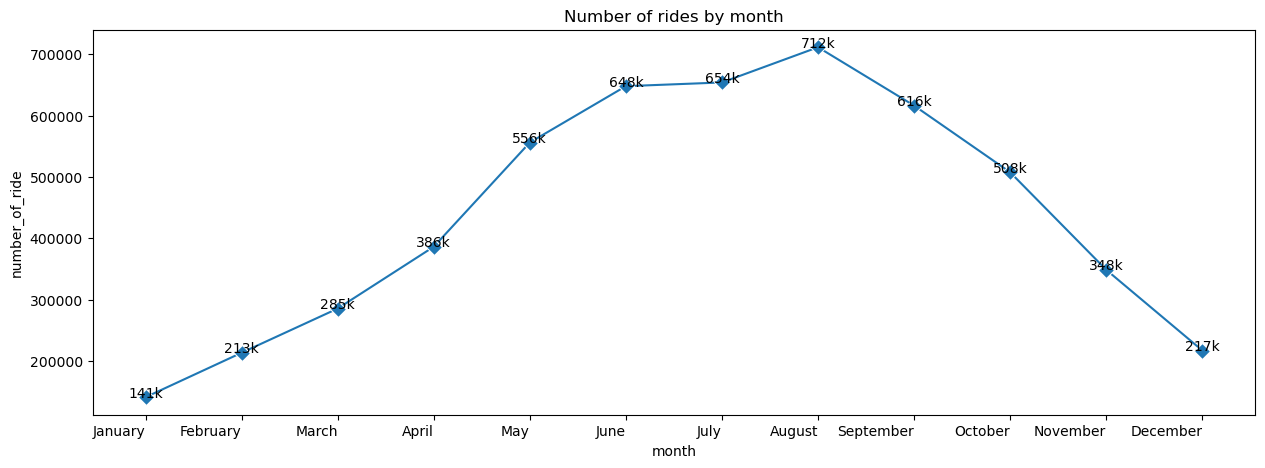

In [49]:
# plotting chart
fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(data = ride_by_month,x='month', y ='number_of_ride', marker = "D", markersize = 8)
plt.xticks(rotation=0, ha='right', fontsize=10)
for x, y in zip(ride_by_month['month'], ride_by_month['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', size = 10)
plt.title('Number of rides by month')
plt.show()


In [50]:
# ride by hours
ride_by_hr = df_ltm.groupby('time_hr').count()['ride_id'].reset_index()
ride_by_hr.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

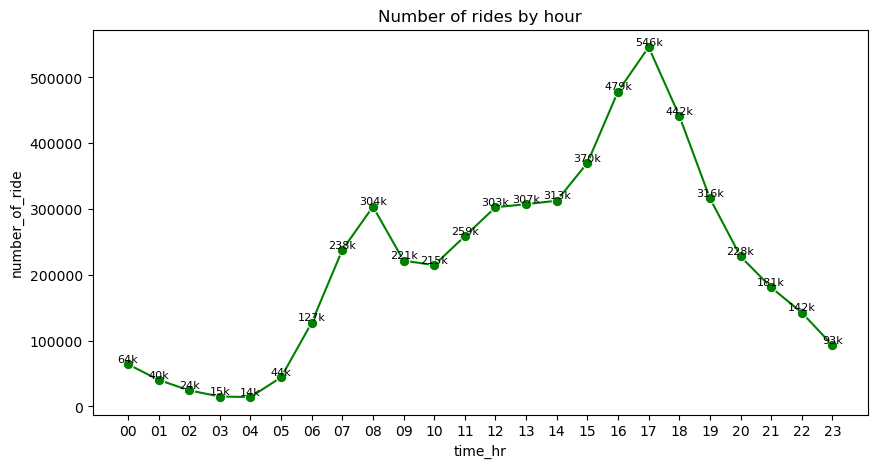

In [51]:
# plotting ride by hour
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(data = ride_by_hr,x='time_hr', y ='number_of_ride', marker = ".", markersize = 15, color = 'green')
plt.xticks(rotation=0, ha='center', fontsize=10)
for x, y in zip(ride_by_hr['time_hr'], ride_by_hr['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', va = 'bottom', size = 8)
plt.title('Number of rides by hour')
plt.show()


In [52]:
# ride by weekday
ride_by_week = df_ltm.groupby('day_of_week').count()['ride_id'].reset_index()
day_order = ['Monday','Tuesday', 'Wednesday','Thursday','Friday', 'Saturday','Sunday']
ride_by_week['day_of_week'] = pd.Categorical(ride_by_week['day_of_week'], categories=day_order, ordered= True)
ride_by_week.rename(columns={'ride_id':'number_of_ride'}, inplace=True)
ride_by_week = ride_by_week.sort_values(by='day_of_week')

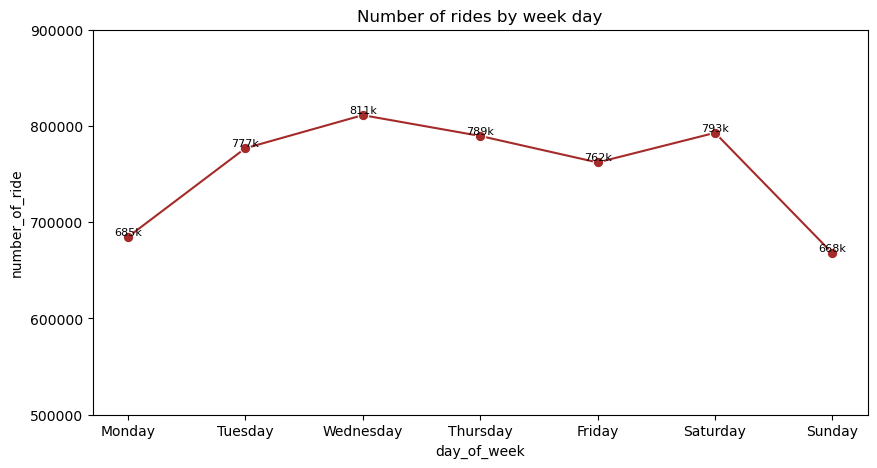

In [53]:
# plotting chart
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(data = ride_by_week,x='day_of_week', y ='number_of_ride', marker = ".", markersize = 15, color = 'brown')
plt.xticks(rotation=0, ha='center', fontsize=10)
for x, y in zip(ride_by_week['day_of_week'], ride_by_week['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', va = 'bottom', size = 8)
plt.yticks(range(500000, 1000000, 100000))
plt.title('Number of rides by week day')
plt.show()

The peak season is from June to August.
The peak hours are from 7am-8:30am and 4pm-6pm, which may match with the going-to-work and off-work hours.
The usage spread quite equally among week days and peaked during Saturday

In [54]:
df_ltm['route'] = df_ltm['start_station_id'] + '-' + df_ltm['end_station_id']

C:\Users\tamla_f1yewqh\AppData\Local\Temp\ipykernel_15388\1443810033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ltm['route'] = df_ltm['start_station_id'] + '-' + df_ltm['end_station_id']


In [55]:
df_ltm.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,ride_length,ride_length_minutes,month,year,time,time_hr,day_of_week,start_neighborhood,end_neighborhood,route
13948649,75F9B1462D4475F2,electric_bike,2024-07-18 09:20:43.684,2024-07-18 09:27:18.348,Stetson Ave & South Water St,TA1308000029,None,None,41.886835,-87.622320,...,0 days 00:06:34.664000,6.58,7,2024,09:20,09,Thursday,Loop,West Loop,NaN
9896404,F93C4FA464A21936,classic_bike,2023-09-12 19:47:45.000,2023-09-12 19:52:55.000,Calumet Ave & 35th St,13345,MLK Jr Dr & 29th St,TA1307000139,41.831379,-87.618034,...,0 days 00:05:10,5.17,9,2023,19:47,19,Tuesday,Douglas,Douglas,13345-TA1307000139
9649598,F687C5FA48AAF001,classic_bike,2023-09-01 15:43:28.000,2023-09-01 16:15:48.000,Broadway & Barry Ave,13137,Broadway & Barry Ave,13137,41.937582,-87.644098,...,0 days 00:32:20,32.33,9,2023,15:43,15,Friday,Lake View,Lake View,13137-13137
13212620,AFE50D7A6B018CC0,classic_bike,2024-06-01 14:41:23.368,2024-06-01 14:51:01.264,Wells St & Evergreen Ave,TA1308000049,Lincoln Ave & Fullerton Ave,TA1309000058,41.906724,-87.634830,...,0 days 00:09:37.896000,9.63,6,2024,14:41,14,Saturday,Old Town,Lincoln Park,TA1308000049-TA1309000058
10624228,29EF6C979BFE07CA,classic_bike,2023-10-16 10:50:51.000,2023-10-16 11:06:25.000,Halsted St & Roosevelt Rd,TA1305000017,Wells St & 19th St,SL-006,41.867324,-87.648625,...,0 days 00:15:34,15.57,10,2023,10:50,10,Monday,"Little Italy, UIC",Chinatown,TA1305000017-SL-006
10418155,E06C92FAAD8D8B60,electric_bike,2023-10-22 09:30:11.000,2023-10-22 10:04:29.000,Clarendon Ave & Leland Ave,TA1307000119,Field Museum,13029,41.967953,-87.649997,...,0 days 00:34:18,34.30,10,2023,09:30,09,Sunday,Uptown,Museum Campus,TA1307000119-13029
9517818,3BBDB6856AD3A1CA,electric_bike,2023-08-12 18:36:58.000,2023-08-12 18:47:49.000,DuSable Lake Shore Dr & Monroe St,13300,None,None,41.881101,-87.616772,...,0 days 00:10:51,10.85,8,2023,18:36,18,Saturday,Loop,Streeterville,NaN
9403672,E1DF437AE604ACCC,electric_bike,2023-08-03 18:30:52.000,2023-08-03 18:41:37.000,Broadway & Ridge Ave,15578,Clark St & Montrose Ave,KA1503000022,41.984082,-87.660257,...,0 days 00:10:45,10.75,8,2023,18:30,18,Thursday,Edgewater,Lake View,15578-KA1503000022
9302249,FFB0CBACC4D3BE39,classic_bike,2023-08-30 16:15:07.000,2023-08-30 16:27:10.000,Southport Ave & Waveland Ave,13235,Leavitt St & Addison St,KA1504000143,41.948150,-87.663940,...,0 days 00:12:03,12.05,8,2023,16:15,16,Wednesday,Wrigleyville,North Center,13235-KA1504000143
14324217,D49F0C3C90356119,electric_bike,2024-07-10 13:31:17.214,2024-07-10 13:44:26.817,Lincolnwood Dr & Central St,E014,Central St Metra,E006,42.064803,-87.715348,...,0 days 00:13:09.603000,13.16,7,2024,13:31,13,Wednesday,NaN,NaN,E014-E006


In [127]:
# indentify the most popular routes 
popular_routes = df_ltm.groupby('route').count()['ride_id'].reset_index().sort_values(by = 'ride_id', ascending=False).head(10)
popular_routes[['start_id','end_id']]  = popular_routes['route'].str.split('-', expand=True)
popular_routes.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

In [128]:
popular_routes

,route,number_of_ride,start_id,end_id
25214,13217-13216,6081,13217,13216
25026,13216-13217,6004,13216,13217
4579,13022-13022,5766,13022,13022
86062,KA1503000014-KA1504000076,5702,KA1503000014,KA1504000076
86058,KA1503000014-KA1503000071,5357,KA1503000014,KA1503000071
91014,KA1504000076-KA1503000014,5234,KA1504000076,KA1503000014
90358,KA1503000071-KA1503000014,5094,KA1503000071,KA1503000014
35863,13300-13300,4956,13300,13300
35787,13300-13022,4245,13300,13022
38575,13332-TA1307000130,3151,13332,TA1307000130


In [129]:
df2.head(5)

,ID,Station Name,Short Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location,station_neighborhood
0,a3ad5c90-a135-11e9-9cda-0a87ae2ba916,Dorchester Ave & 49th St,KA1503000069,15,15,In Service,41.805772,-87.592464,POINT (-87.592464 41.805772),Kenwood
1,1571105068000485406,Narragansett & Irving Park,NaN,9,9,In Service,41.952614,-87.785383,POINT (-87.7853829 41.952614),Dunning
2,a3b2af02-a135-11e9-9cda-0a87ae2ba916,MLK Jr Dr & 83rd St,586,11,11,In Service,41.743116,-87.614800,POINT (-87.6148 41.743116),Chatham
3,1594046405283107528,California & 16th St,NaN,9,9,In Service,41.859228,-87.695562,POINT (-87.695562 41.859228),North Lawndale
4,a3b13836-a135-11e9-9cda-0a87ae2ba916,Kenton Ave & Madison St,537,11,11,In Service,41.880708,-87.741018,POINT (-87.741018 41.880708),Austin


In [130]:
# Popular routes start locations and capacity
popular_routes = pd.merge(popular_routes, df2,left_on= 'start_id', right_on='Short Name' ,how = 'left')

In [131]:
popular_routes.sample(5)

,route,number_of_ride,start_id,end_id,ID,Station Name,Short Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location,station_neighborhood
0,13217-13216,6081,13217,13216,a3a639f5-a135-11e9-9cda-0a87ae2ba916,Calumet Ave & 33rd St,13217,11,11,In Service,41.834900,-87.617930,POINT (-87.61793 41.8349),Douglas
3,KA1503000014-KA1504000076,5702,KA1503000014,KA1504000076,a3ad8fd9-a135-11e9-9cda-0a87ae2ba916,Ellis Ave & 60th St,KA1503000014,19,19,In Service,41.785097,-87.601073,POINT (-87.6010727606 41.78509714636),Woodlawn
6,KA1503000071-KA1503000014,5094,KA1503000071,KA1503000014,a3ad8072-a135-11e9-9cda-0a87ae2ba916,University Ave & 57th St,KA1503000071,31,31,In Service,41.791478,-87.599861,POINT (-87.599861 41.791478),Hyde Park
7,13300-13300,4956,13300,13300,a3a4d588-a135-11e9-9cda-0a87ae2ba916,DuSable Lake Shore Dr & Monroe St,13300,39,39,In Service,41.880958,-87.616743,POINT (-87.616743 41.880958),Loop
5,KA1504000076-KA1503000014,5234,KA1504000076,KA1503000014,a3ad711d-a135-11e9-9cda-0a87ae2ba916,Ellis Ave & 55th St,KA1504000076,19,19,In Service,41.794301,-87.601450,POINT (-87.6014497734 41.79430062054),Hyde Park


In [132]:
popular_routes.rename(columns = {'Latitude':'start_lat','Total Docks':'start_capacity','Longitude' :'start_lon', 'station_neighborhood':'start_neighborhood','Station Name':'start_name'}, inplace= True)

In [133]:
popular_routes.sample(5)

,route,number_of_ride,start_id,end_id,ID,start_name,Short Name,start_capacity,Docks in Service,Status,start_lat,start_lon,Location,start_neighborhood
4,KA1503000014-KA1503000071,5357,KA1503000014,KA1503000071,a3ad8fd9-a135-11e9-9cda-0a87ae2ba916,Ellis Ave & 60th St,KA1503000014,19,19,In Service,41.785097,-87.601073,POINT (-87.6010727606 41.78509714636),Woodlawn
8,13300-13022,4245,13300,13022,a3a4d588-a135-11e9-9cda-0a87ae2ba916,DuSable Lake Shore Dr & Monroe St,13300,39,39,In Service,41.880958,-87.616743,POINT (-87.616743 41.880958),Loop
3,KA1503000014-KA1504000076,5702,KA1503000014,KA1504000076,a3ad8fd9-a135-11e9-9cda-0a87ae2ba916,Ellis Ave & 60th St,KA1503000014,19,19,In Service,41.785097,-87.601073,POINT (-87.6010727606 41.78509714636),Woodlawn
7,13300-13300,4956,13300,13300,a3a4d588-a135-11e9-9cda-0a87ae2ba916,DuSable Lake Shore Dr & Monroe St,13300,39,39,In Service,41.880958,-87.616743,POINT (-87.616743 41.880958),Loop
5,KA1504000076-KA1503000014,5234,KA1504000076,KA1503000014,a3ad711d-a135-11e9-9cda-0a87ae2ba916,Ellis Ave & 55th St,KA1504000076,19,19,In Service,41.794301,-87.601450,POINT (-87.6014497734 41.79430062054),Hyde Park


In [134]:
popular_routes = popular_routes.drop(['Short Name','Docks in Service','Status','Location','ID'], axis = 1)

In [135]:
popular_routes

,route,number_of_ride,start_id,end_id,start_name,start_capacity,start_lat,start_lon,start_neighborhood
0,13217-13216,6081,13217,13216,Calumet Ave & 33rd St,11,41.834900,-87.617930,Douglas
1,13216-13217,6004,13216,13217,State St & 33rd St,15,41.834734,-87.625813,Douglas
2,13022-13022,5766,13022,13022,Streeter Dr & Grand Ave,43,41.892278,-87.612043,Streeterville
3,KA1503000014-KA1504000076,5702,KA1503000014,KA1504000076,Ellis Ave & 60th St,19,41.785097,-87.601073,Woodlawn
4,KA1503000014-KA1503000071,5357,KA1503000014,KA1503000071,Ellis Ave & 60th St,19,41.785097,-87.601073,Woodlawn
5,KA1504000076-KA1503000014,5234,KA1504000076,KA1503000014,Ellis Ave & 55th St,19,41.794301,-87.601450,Hyde Park
6,KA1503000071-KA1503000014,5094,KA1503000071,KA1503000014,University Ave & 57th St,31,41.791478,-87.599861,Hyde Park
7,13300-13300,4956,13300,13300,DuSable Lake Shore Dr & Monroe St,39,41.880958,-87.616743,Loop
8,13300-13022,4245,13300,13022,DuSable Lake Shore Dr & Monroe St,39,41.880958,-87.616743,Loop
9,13332-TA1307000130,3151,13332,TA1307000130,Loomis St & Lexington St,19,41.872229,-87.661364,"Little Italy, UIC"


In [136]:
# popular routes end locations and capacity
popular_routes = pd.merge(popular_routes, df2,left_on= 'end_id', right_on='Short Name' ,how = 'left')

In [138]:
popular_routes.rename(columns = {'Latitude':'end_lat','Total Docks':'end_capacity','Longitude' :'end_lon', 'station_neighborhood':'end_neighborhood','Station Name':'end_name'}, inplace= True)

In [140]:
popular_routes = popular_routes.drop(['Short Name','Docks in Service','Status','Location','ID'], axis = 1)

## 2. Customer behaviors:
- [ ] What are the most popular ride type?
- [ ] What are the average ride time, distance by each type of ride?
- [ ] Casual vs member: what are their preference? How is the growth rate of these 2 segments?

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733947 entries, 0 to 5734380
Data columns (total 21 columns):
 #   Column               Dtype          
---  ------               -----          
 0   ride_id              object         
 1   rideable_type        object         
 2   started_at           datetime64[ns] 
 3   ended_at             datetime64[ns] 
 4   start_station_name   object         
 5   start_station_id     object         
 6   end_station_name     object         
 7   end_station_id       object         
 8   start_lat            float64        
 9   start_lng            float64        
 10  end_lat              float64        
 11  end_lng              float64        
 12  member_casual        object         
 13  distance_km          float64        
 14  ride_length          timedelta64[ns]
 15  ride_length_minutes  float64        
 16  month                int32          
 17  time                 object         
 18  time_hr              object         
 19  day_o

In [141]:
ride_type = df_ltm.groupby('rideable_type').agg({'distance_km': 'mean', 'ride_length_minutes' : 'mean','ride_id':'count'}
                                            ).rename(columns = {'distance_km':'average_distance','ride_length_minutes':'average_time','ride_id': 'ride_number'}).reset_index()
ride_type

,rideable_type,average_distance,average_time,ride_number
0,classic_bike,1.794761,11.906878,2565517
1,docked_bike,1.916395,18.685466,9467
2,electric_bike,2.196062,10.290417,2709084


From Sep 2023, Divvy stopped their docked bike service.

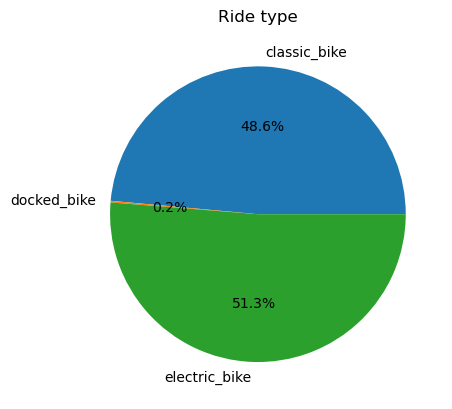

In [142]:
# ploting pie chart
fig, ax = plt.subplots()

ax.pie(ride_type['ride_number'], labels = ride_type['rideable_type'].to_list(), autopct='%1.1f%%')
ax.set_title('Ride type')

plt.show()


In [143]:
ride_by_member = df_ltm.groupby(['member_casual','rideable_type']).agg({'ride_id':'count','distance_km':'mean','ride_length_minutes':'mean'}).reset_index()

In [144]:
ride_by_member

,member_casual,rideable_type,ride_id,distance_km,ride_length_minutes
0,casual,classic_bike,780713,1.805854,14.191999
1,casual,docked_bike,9467,1.916395,18.685466
2,casual,electric_bike,962919,2.034457,11.024575
3,member,classic_bike,1784804,1.789909,10.907315
4,member,electric_bike,1746165,2.285179,9.885566


## Save clean file

In [145]:
df.to_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\Data analytics\data_merged.parquet')

In [146]:
df2.to_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\Data analytics\stations.parquet')